# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

acc = lambda v, v_pred: np.mean(v == v_pred)

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr_rt in learning_rates:
    for reg_st in regularization_strengths:
        svm = LinearSVM()
        hist_loss = svm.train(X_train_feats, y_train, learning_rate=lr_rt, reg=reg_st,
                      num_iters=500, verbose=False)
        
        tr_acc = np.mean(y_train == svm.predict(X_train_feats))
        val_acc = np.mean(y_val == svm.predict(X_val_feats))
        
        results[(lr_rt, reg_st)] = (tr_acc, val_acc)
        
        if (val_acc > best_val):
            best_val = val_acc
            best_svm = svm


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print("{lr} lr {reg} reg {trainacc} train accuracy: {valacc} val accuracy:".\
    format( lr = lr, reg = reg, trainacc = train_accuracy, valacc = val_accuracy))
    
print(" best validation accuracy achieved during cross-validation: {best_val}".format(best_val = best_val))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****



1e-09 lr 50000.0 reg 0.10987755102040817 train accuracy: 0.109 val accuracy:
1e-09 lr 500000.0 reg 0.1356734693877551 train accuracy: 0.164 val accuracy:
1e-09 lr 5000000.0 reg 0.09912244897959184 train accuracy: 0.098 val accuracy:
1e-08 lr 50000.0 reg 0.09695918367346938 train accuracy: 0.099 val accuracy:
1e-08 lr 500000.0 reg 0.10746938775510204 train accuracy: 0.115 val accuracy:
1e-08 lr 5000000.0 reg 0.41191836734693876 train accuracy: 0.411 val accuracy:
1e-07 lr 50000.0 reg 0.0946326530612245 train accuracy: 0.095 val accuracy:
1e-07 lr 500000.0 reg 0.4012857142857143 train accuracy: 0.39 val accuracy:
1e-07 lr 5000000.0 reg 0.3720204081632653 train accuracy: 0.353 val accuracy:
 best validation accuracy achieved during cross-validation: 0.411


In [5]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.425


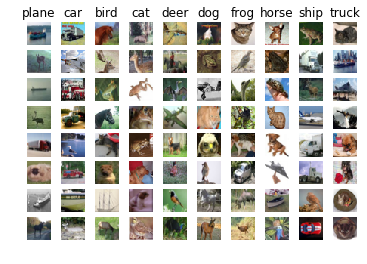

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [8]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)

best_net = None
best_val = -1

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
input_size =  X_train_feats.shape[1]
learning_rates = [1e-3, 1e-4, 1e-5, 1e-7, 5e-7, 2e-6, 1e-8, 1e-9]
regularization_strengths = [0.05, 0.5, 1, 5, 25, 100, 5000, 1e6]
hidden_size = [10, 50, 150, 500, 1500]




acc = lambda v, v_pred: np.mean(v == v_pred)

for lr in learning_rates:
    for k in regularization_strengths:
        for h in hidden_size:
            net = TwoLayerNet(input_size, h, num_classes)
            net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=1500, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=k, verbose=True)
            y_train_pred = net.predict(X_train_feats)
            y_val_pred = net.predict(X_val_feats)
            trainbest = acc(y_train, y_train_pred)
            valbest = acc(y_val, y_val_pred)
            if valbest > best_val:
                best_val = valbest
                best_net = net
            results[(lr, k)] = (trainbest, valbest)
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print("{lr} lr {reg} reg {trainacc} train accuracy: {valacc} val accuracy:".\
    format( lr = lr, reg = reg, trainacc = train_accuracy, valacc = val_accuracy))


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


iteration 0 / 1500: loss 2.302586
iteration 100 / 1500: loss 2.302584
iteration 200 / 1500: loss 2.302593
iteration 300 / 1500: loss 2.302608
iteration 400 / 1500: loss 2.302590
iteration 500 / 1500: loss 2.302595
iteration 600 / 1500: loss 2.302599
iteration 700 / 1500: loss 2.302591
iteration 800 / 1500: loss 2.302560
iteration 900 / 1500: loss 2.302582
iteration 1000 / 1500: loss 2.302493
iteration 1100 / 1500: loss 2.302573
iteration 1200 / 1500: loss 2.302628
iteration 1300 / 1500: loss 2.302521
iteration 1400 / 1500: loss 2.302483
iteration 0 / 1500: loss 2.302587
iteration 100 / 1500: loss 2.302581
iteration 200 / 1500: loss 2.302568
iteration 300 / 1500: loss 2.302590
iteration 400 / 1500: loss 2.302564
iteration 500 / 1500: loss 2.302579
iteration 600 / 1500: loss 2.302615
iteration 700 / 1500: loss 2.302555
iteration 800 / 1500: loss 2.302584
iteration 900 / 1500: loss 2.302594
iteration 1000 / 1500: loss 2.302569
iteration 1100 / 1500: loss 2.302577
iteration 1200 / 1500: lo

iteration 200 / 1500: loss 2.302608
iteration 300 / 1500: loss 2.302628
iteration 400 / 1500: loss 2.302600
iteration 500 / 1500: loss 2.302554
iteration 600 / 1500: loss 2.302616
iteration 700 / 1500: loss 2.302517
iteration 800 / 1500: loss 2.302563
iteration 900 / 1500: loss 2.302616
iteration 1000 / 1500: loss 2.302710
iteration 1100 / 1500: loss 2.302529
iteration 1200 / 1500: loss 2.302556
iteration 1300 / 1500: loss 2.302744
iteration 1400 / 1500: loss 2.302532
iteration 0 / 1500: loss 2.302798
iteration 100 / 1500: loss 2.302673
iteration 200 / 1500: loss 2.302607
iteration 300 / 1500: loss 2.302579
iteration 400 / 1500: loss 2.302554
iteration 500 / 1500: loss 2.302633
iteration 600 / 1500: loss 2.302625
iteration 700 / 1500: loss 2.302643
iteration 800 / 1500: loss 2.302467
iteration 900 / 1500: loss 2.302614
iteration 1000 / 1500: loss 2.302531
iteration 1100 / 1500: loss 2.302631
iteration 1200 / 1500: loss 2.302516
iteration 1300 / 1500: loss 2.302545
iteration 1400 / 1500

D:\tdebusschere\CodeRepo\computer-vision\assignment1\cs231n\classifiers\neural_net.py:92: RuntimeWarning: overflow encountered in exp
  exp_scores = np.exp(scores)
D:\tdebusschere\CodeRepo\computer-vision\assignment1\cs231n\classifiers\neural_net.py:93: RuntimeWarning: invalid value encountered in true_divide
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
D:\tdebusschere\CodeRepo\computer-vision\assignment1\cs231n\classifiers\neural_net.py:97: RuntimeWarning: divide by zero encountered in log
  corect_logprobs = -np.log(probs[range(N), y])
D:\tdebusschere\CodeRepo\computer-vision\assignment1\cs231n\classifiers\neural_net.py:128: RuntimeWarning: invalid value encountered in greater_equal
  dy1 = dh1 * (y1 >= 0)


iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 2.510236
iteration 100 / 1500: loss nan
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 2.912858
iteration 100 / 1500: loss nan
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: l

iteration 1000 / 1500: loss 2.302605
iteration 1100 / 1500: loss 2.302599
iteration 1200 / 1500: loss 2.302602
iteration 1300 / 1500: loss 2.302603
iteration 1400 / 1500: loss 2.302605
iteration 0 / 1500: loss 2.302646
iteration 100 / 1500: loss 2.302646
iteration 200 / 1500: loss 2.302643
iteration 300 / 1500: loss 2.302643
iteration 400 / 1500: loss 2.302649
iteration 500 / 1500: loss 2.302641
iteration 600 / 1500: loss 2.302641
iteration 700 / 1500: loss 2.302640
iteration 800 / 1500: loss 2.302639
iteration 900 / 1500: loss 2.302649
iteration 1000 / 1500: loss 2.302643
iteration 1100 / 1500: loss 2.302636
iteration 1200 / 1500: loss 2.302648
iteration 1300 / 1500: loss 2.302634
iteration 1400 / 1500: loss 2.302645
iteration 0 / 1500: loss 2.302789
iteration 100 / 1500: loss 2.302786
iteration 200 / 1500: loss 2.302786
iteration 300 / 1500: loss 2.302783
iteration 400 / 1500: loss 2.302779
iteration 500 / 1500: loss 2.302778
iteration 600 / 1500: loss 2.302778
iteration 700 / 1500: 

iteration 1200 / 1500: loss 2.302585
iteration 1300 / 1500: loss 2.302587
iteration 1400 / 1500: loss 2.302586
iteration 0 / 1500: loss 2.305665
iteration 100 / 1500: loss 2.304499
iteration 200 / 1500: loss 2.303774
iteration 300 / 1500: loss 2.303333
iteration 400 / 1500: loss 2.303060
iteration 500 / 1500: loss 2.302887
iteration 600 / 1500: loss 2.302783
iteration 700 / 1500: loss 2.302714
iteration 800 / 1500: loss 2.302669
iteration 900 / 1500: loss 2.302643
iteration 1000 / 1500: loss 2.302622
iteration 1100 / 1500: loss 2.302613
iteration 1200 / 1500: loss 2.302603
iteration 1300 / 1500: loss 2.302600
iteration 1400 / 1500: loss 2.302591
iteration 0 / 1500: loss 2.312792
iteration 100 / 1500: loss 2.308926
iteration 200 / 1500: loss 2.306522
iteration 300 / 1500: loss 2.305067
iteration 400 / 1500: loss 2.304168
iteration 500 / 1500: loss 2.303592
iteration 600 / 1500: loss 2.303248
iteration 700 / 1500: loss 2.303012
iteration 800 / 1500: loss 2.302868
iteration 900 / 1500: lo

iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 410.041739
iteration 100 / 1500: loss nan
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 1235.051717
iteration 100 / 1500: loss nan
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 15

iteration 1000 / 1500: loss 2.302707
iteration 1100 / 1500: loss 2.302707
iteration 1200 / 1500: loss 2.302707
iteration 1300 / 1500: loss 2.302706
iteration 1400 / 1500: loss 2.302706
iteration 0 / 1500: loss 2.302995
iteration 100 / 1500: loss 2.302994
iteration 200 / 1500: loss 2.302992
iteration 300 / 1500: loss 2.302992
iteration 400 / 1500: loss 2.302992
iteration 500 / 1500: loss 2.302990
iteration 600 / 1500: loss 2.302990
iteration 700 / 1500: loss 2.302989
iteration 800 / 1500: loss 2.302988
iteration 900 / 1500: loss 2.302988
iteration 1000 / 1500: loss 2.302988
iteration 1100 / 1500: loss 2.302987
iteration 1200 / 1500: loss 2.302986
iteration 1300 / 1500: loss 2.302985
iteration 1400 / 1500: loss 2.302985
iteration 0 / 1500: loss 2.303817
iteration 100 / 1500: loss 2.303815
iteration 200 / 1500: loss 2.303812
iteration 300 / 1500: loss 2.303810
iteration 400 / 1500: loss 2.303808
iteration 500 / 1500: loss 2.303806
iteration 600 / 1500: loss 2.303804
iteration 700 / 1500: 

iteration 1200 / 1500: loss 2.304149
iteration 1300 / 1500: loss 2.303933
iteration 1400 / 1500: loss 2.303748
iteration 0 / 1500: loss 2.343609
iteration 100 / 1500: loss 2.336504
iteration 200 / 1500: loss 2.330632
iteration 300 / 1500: loss 2.325896
iteration 400 / 1500: loss 2.322044
iteration 500 / 1500: loss 2.318842
iteration 600 / 1500: loss 2.316280
iteration 700 / 1500: loss 2.314122
iteration 800 / 1500: loss 2.312356
iteration 900 / 1500: loss 2.310888
iteration 1000 / 1500: loss 2.309649
iteration 1100 / 1500: loss 2.308635
iteration 1200 / 1500: loss 2.307768
iteration 1300 / 1500: loss 2.307050
iteration 1400 / 1500: loss 2.306440
iteration 0 / 1500: loss 2.425925
iteration 100 / 1500: loss 2.404561
iteration 200 / 1500: loss 2.386908
iteration 300 / 1500: loss 2.372670
iteration 400 / 1500: loss 2.361090
iteration 500 / 1500: loss 2.351465
iteration 600 / 1500: loss 2.343759
iteration 700 / 1500: loss 2.337268
iteration 800 / 1500: loss 2.331962
iteration 900 / 1500: lo

iteration 800 / 1500: loss 2.302606
iteration 900 / 1500: loss 2.302606
iteration 1000 / 1500: loss 2.302606
iteration 1100 / 1500: loss 2.302605
iteration 1200 / 1500: loss 2.302606
iteration 1300 / 1500: loss 2.302606
iteration 1400 / 1500: loss 2.302606
iteration 0 / 1500: loss 2.302647
iteration 100 / 1500: loss 2.302646
iteration 200 / 1500: loss 2.302647
iteration 300 / 1500: loss 2.302646
iteration 400 / 1500: loss 2.302647
iteration 500 / 1500: loss 2.302646
iteration 600 / 1500: loss 2.302647
iteration 700 / 1500: loss 2.302646
iteration 800 / 1500: loss 2.302646
iteration 900 / 1500: loss 2.302646
iteration 1000 / 1500: loss 2.302647
iteration 1100 / 1500: loss 2.302646
iteration 1200 / 1500: loss 2.302647
iteration 1300 / 1500: loss 2.302646
iteration 1400 / 1500: loss 2.302647
iteration 0 / 1500: loss 2.302589
iteration 100 / 1500: loss 2.302589
iteration 200 / 1500: loss 2.302589
iteration 300 / 1500: loss 2.302589
iteration 400 / 1500: loss 2.302589
iteration 500 / 1500: 

iteration 1000 / 1500: loss 2.304633
iteration 1100 / 1500: loss 2.304633
iteration 1200 / 1500: loss 2.304633
iteration 1300 / 1500: loss 2.304633
iteration 1400 / 1500: loss 2.304633
iteration 0 / 1500: loss 2.308740
iteration 100 / 1500: loss 2.308739
iteration 200 / 1500: loss 2.308739
iteration 300 / 1500: loss 2.308739
iteration 400 / 1500: loss 2.308738
iteration 500 / 1500: loss 2.308737
iteration 600 / 1500: loss 2.308737
iteration 700 / 1500: loss 2.308736
iteration 800 / 1500: loss 2.308736
iteration 900 / 1500: loss 2.308735
iteration 1000 / 1500: loss 2.308735
iteration 1100 / 1500: loss 2.308734
iteration 1200 / 1500: loss 2.308734
iteration 1300 / 1500: loss 2.308733
iteration 1400 / 1500: loss 2.308733
iteration 0 / 1500: loss 2.302780
iteration 100 / 1500: loss 2.302780
iteration 200 / 1500: loss 2.302780
iteration 300 / 1500: loss 2.302780
iteration 400 / 1500: loss 2.302780
iteration 500 / 1500: loss 2.302780
iteration 600 / 1500: loss 2.302780
iteration 700 / 1500: 

iteration 1200 / 1500: loss 3.028776
iteration 1300 / 1500: loss 2.976621
iteration 1400 / 1500: loss 2.928842
iteration 0 / 1500: loss 8.437196
iteration 100 / 1500: loss 7.880829
iteration 200 / 1500: loss 7.375175
iteration 300 / 1500: loss 6.927209
iteration 400 / 1500: loss 6.528031
iteration 500 / 1500: loss 6.164877
iteration 600 / 1500: loss 5.847467
iteration 700 / 1500: loss 5.556142
iteration 800 / 1500: loss 5.296967
iteration 900 / 1500: loss 5.062695
iteration 1000 / 1500: loss 4.848723
iteration 1100 / 1500: loss 4.659101
iteration 1200 / 1500: loss 4.483602
iteration 1300 / 1500: loss 4.326963
iteration 1400 / 1500: loss 4.183465
iteration 0 / 1500: loss 10.052135
iteration 100 / 1500: loss 2.302585
iteration 200 / 1500: loss 2.302585
iteration 300 / 1500: loss 2.302585
iteration 400 / 1500: loss 2.302585
iteration 500 / 1500: loss 2.302585
iteration 600 / 1500: loss 2.302585
iteration 700 / 1500: loss 2.302585
iteration 800 / 1500: loss 2.302585
iteration 900 / 1500: l

iteration 1400 / 1500: loss 2.302788
iteration 0 / 1500: loss 2.303200
iteration 100 / 1500: loss 2.303200
iteration 200 / 1500: loss 2.303200
iteration 300 / 1500: loss 2.303200
iteration 400 / 1500: loss 2.303200
iteration 500 / 1500: loss 2.303200
iteration 600 / 1500: loss 2.303200
iteration 700 / 1500: loss 2.303200
iteration 800 / 1500: loss 2.303200
iteration 900 / 1500: loss 2.303200
iteration 1000 / 1500: loss 2.303200
iteration 1100 / 1500: loss 2.303200
iteration 1200 / 1500: loss 2.303200
iteration 1300 / 1500: loss 2.303200
iteration 1400 / 1500: loss 2.303200
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 2.302593
iteration 200 / 1500: loss 2.302594
iteration 300 / 1500: loss 2.302594
iteration 400 / 1500: loss 2.302593
iteration 500 / 1500: loss 2.302593
iteration 600 / 1500: loss 2.302594
iteration 700 / 1500: loss 2.302594
iteration 800 / 1500: loss 2.302593
iteration 900 / 1500: loss 2.302593
iteration 1000 / 1500: loss 2.302593
iteration 1100 / 1500: lo

iteration 100 / 1500: loss 2.333234
iteration 200 / 1500: loss 2.333161
iteration 300 / 1500: loss 2.333091
iteration 400 / 1500: loss 2.333022
iteration 500 / 1500: loss 2.332953
iteration 600 / 1500: loss 2.332888
iteration 700 / 1500: loss 2.332824
iteration 800 / 1500: loss 2.332761
iteration 900 / 1500: loss 2.332699
iteration 1000 / 1500: loss 2.332639
iteration 1100 / 1500: loss 2.332581
iteration 1200 / 1500: loss 2.332523
iteration 1300 / 1500: loss 2.332468
iteration 1400 / 1500: loss 2.332413
iteration 0 / 1500: loss 2.303394
iteration 100 / 1500: loss 2.303386
iteration 200 / 1500: loss 2.303378
iteration 300 / 1500: loss 2.303371
iteration 400 / 1500: loss 2.303364
iteration 500 / 1500: loss 2.303357
iteration 600 / 1500: loss 2.303351
iteration 700 / 1500: loss 2.303344
iteration 800 / 1500: loss 2.303338
iteration 900 / 1500: loss 2.303332
iteration 1000 / 1500: loss 2.303326
iteration 1100 / 1500: loss 2.303320
iteration 1200 / 1500: loss 2.303314
iteration 1300 / 1500:

iteration 300 / 1500: loss 2.302585
iteration 400 / 1500: loss 2.302585
iteration 500 / 1500: loss 2.302585
iteration 600 / 1500: loss 2.302585
iteration 700 / 1500: loss 2.302585
iteration 800 / 1500: loss 2.302585
iteration 900 / 1500: loss 2.302585
iteration 1000 / 1500: loss 2.302585
iteration 1100 / 1500: loss 2.302585
iteration 1200 / 1500: loss 2.302585
iteration 1300 / 1500: loss 2.302585
iteration 1400 / 1500: loss 2.302585
iteration 0 / 1500: loss 2.302586
iteration 100 / 1500: loss 2.302585
iteration 200 / 1500: loss 2.302586
iteration 300 / 1500: loss 2.302586
iteration 400 / 1500: loss 2.302586
iteration 500 / 1500: loss 2.302586
iteration 600 / 1500: loss 2.302586
iteration 700 / 1500: loss 2.302585
iteration 800 / 1500: loss 2.302585
iteration 900 / 1500: loss 2.302586
iteration 1000 / 1500: loss 2.302585
iteration 1100 / 1500: loss 2.302585
iteration 1200 / 1500: loss 2.302586
iteration 1300 / 1500: loss 2.302586
iteration 1400 / 1500: loss 2.302586
iteration 0 / 1500: 

iteration 500 / 1500: loss 2.303807
iteration 600 / 1500: loss 2.303806
iteration 700 / 1500: loss 2.303806
iteration 800 / 1500: loss 2.303805
iteration 900 / 1500: loss 2.303806
iteration 1000 / 1500: loss 2.303805
iteration 1100 / 1500: loss 2.303804
iteration 1200 / 1500: loss 2.303804
iteration 1300 / 1500: loss 2.303804
iteration 1400 / 1500: loss 2.303803
iteration 0 / 1500: loss 2.302627
iteration 100 / 1500: loss 2.302627
iteration 200 / 1500: loss 2.302627
iteration 300 / 1500: loss 2.302627
iteration 400 / 1500: loss 2.302627
iteration 500 / 1500: loss 2.302627
iteration 600 / 1500: loss 2.302626
iteration 700 / 1500: loss 2.302626
iteration 800 / 1500: loss 2.302626
iteration 900 / 1500: loss 2.302626
iteration 1000 / 1500: loss 2.302626
iteration 1100 / 1500: loss 2.302626
iteration 1200 / 1500: loss 2.302626
iteration 1300 / 1500: loss 2.302626
iteration 1400 / 1500: loss 2.302626
iteration 0 / 1500: loss 2.302790
iteration 100 / 1500: loss 2.302790
iteration 200 / 1500: 

iteration 700 / 1500: loss 2.397742
iteration 800 / 1500: loss 2.394634
iteration 900 / 1500: loss 2.391684
iteration 1000 / 1500: loss 2.388854
iteration 1100 / 1500: loss 2.386225
iteration 1200 / 1500: loss 2.383675
iteration 1300 / 1500: loss 2.381294
iteration 1400 / 1500: loss 2.379013
iteration 0 / 1500: loss 2.344617
iteration 100 / 1500: loss 2.308809
iteration 200 / 1500: loss 2.303507
iteration 300 / 1500: loss 2.302729
iteration 400 / 1500: loss 2.302609
iteration 500 / 1500: loss 2.302589
iteration 600 / 1500: loss 2.302586
iteration 700 / 1500: loss 2.302585
iteration 800 / 1500: loss 2.302585
iteration 900 / 1500: loss 2.302585
iteration 1000 / 1500: loss 2.302585
iteration 1100 / 1500: loss 2.302585
iteration 1200 / 1500: loss 2.302585
iteration 1300 / 1500: loss 2.302585
iteration 1400 / 1500: loss 2.302585
iteration 0 / 1500: loss 2.513004
iteration 100 / 1500: loss 2.333741
iteration 200 / 1500: loss 2.307203
iteration 300 / 1500: loss 2.303306
iteration 400 / 1500: 

iteration 900 / 1500: loss 2.302647
iteration 1000 / 1500: loss 2.302647
iteration 1100 / 1500: loss 2.302647
iteration 1200 / 1500: loss 2.302647
iteration 1300 / 1500: loss 2.302647
iteration 1400 / 1500: loss 2.302647
iteration 0 / 1500: loss 2.302589
iteration 100 / 1500: loss 2.302589
iteration 200 / 1500: loss 2.302589
iteration 300 / 1500: loss 2.302589
iteration 400 / 1500: loss 2.302589
iteration 500 / 1500: loss 2.302589
iteration 600 / 1500: loss 2.302589
iteration 700 / 1500: loss 2.302589
iteration 800 / 1500: loss 2.302589
iteration 900 / 1500: loss 2.302589
iteration 1000 / 1500: loss 2.302589
iteration 1100 / 1500: loss 2.302589
iteration 1200 / 1500: loss 2.302589
iteration 1300 / 1500: loss 2.302589
iteration 1400 / 1500: loss 2.302589
iteration 0 / 1500: loss 2.302606
iteration 100 / 1500: loss 2.302606
iteration 200 / 1500: loss 2.302606
iteration 300 / 1500: loss 2.302606
iteration 400 / 1500: loss 2.302606
iteration 500 / 1500: loss 2.302606
iteration 600 / 1500: 

iteration 1100 / 1500: loss 2.308761
iteration 1200 / 1500: loss 2.308761
iteration 1300 / 1500: loss 2.308760
iteration 1400 / 1500: loss 2.308760
iteration 0 / 1500: loss 2.302791
iteration 100 / 1500: loss 2.302791
iteration 200 / 1500: loss 2.302791
iteration 300 / 1500: loss 2.302790
iteration 400 / 1500: loss 2.302790
iteration 500 / 1500: loss 2.302790
iteration 600 / 1500: loss 2.302790
iteration 700 / 1500: loss 2.302790
iteration 800 / 1500: loss 2.302790
iteration 900 / 1500: loss 2.302790
iteration 1000 / 1500: loss 2.302790
iteration 1100 / 1500: loss 2.302790
iteration 1200 / 1500: loss 2.302790
iteration 1300 / 1500: loss 2.302790
iteration 1400 / 1500: loss 2.302790
iteration 0 / 1500: loss 2.303615
iteration 100 / 1500: loss 2.303615
iteration 200 / 1500: loss 2.303615
iteration 300 / 1500: loss 2.303615
iteration 400 / 1500: loss 2.303614
iteration 500 / 1500: loss 2.303614
iteration 600 / 1500: loss 2.303614
iteration 700 / 1500: loss 2.303614
iteration 800 / 1500: l

iteration 1300 / 1500: loss 7.831284
iteration 1400 / 1500: loss 7.790791
iteration 0 / 1500: loss 10.779210
iteration 100 / 1500: loss 3.557691
iteration 200 / 1500: loss 2.488612
iteration 300 / 1500: loss 2.331623
iteration 400 / 1500: loss 2.307322
iteration 500 / 1500: loss 2.303364
iteration 600 / 1500: loss 2.302724
iteration 700 / 1500: loss 2.302610
iteration 800 / 1500: loss 2.302590
iteration 900 / 1500: loss 2.302586
iteration 1000 / 1500: loss 2.302585
iteration 1100 / 1500: loss 2.302585
iteration 1200 / 1500: loss 2.302585
iteration 1300 / 1500: loss 2.302585
iteration 1400 / 1500: loss 2.302585
iteration 0 / 1500: loss 42.726955
iteration 100 / 1500: loss 8.288088
iteration 200 / 1500: loss 3.189734
iteration 300 / 1500: loss 2.441063
iteration 400 / 1500: loss 2.325175
iteration 500 / 1500: loss 2.306301
iteration 600 / 1500: loss 2.303249
iteration 700 / 1500: loss 2.302704
iteration 800 / 1500: loss 2.302607
iteration 900 / 1500: loss 2.302589
iteration 1000 / 1500: 

iteration 1400 / 1500: loss 2.303203
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 2.302593
iteration 200 / 1500: loss 2.302593
iteration 300 / 1500: loss 2.302593
iteration 400 / 1500: loss 2.302593
iteration 500 / 1500: loss 2.302593
iteration 600 / 1500: loss 2.302593
iteration 700 / 1500: loss 2.302593
iteration 800 / 1500: loss 2.302593
iteration 900 / 1500: loss 2.302593
iteration 1000 / 1500: loss 2.302593
iteration 1100 / 1500: loss 2.302593
iteration 1200 / 1500: loss 2.302593
iteration 1300 / 1500: loss 2.302593
iteration 1400 / 1500: loss 2.302593
iteration 0 / 1500: loss 2.302625
iteration 100 / 1500: loss 2.302625
iteration 200 / 1500: loss 2.302625
iteration 300 / 1500: loss 2.302625
iteration 400 / 1500: loss 2.302625
iteration 500 / 1500: loss 2.302625
iteration 600 / 1500: loss 2.302625
iteration 700 / 1500: loss 2.302625
iteration 800 / 1500: loss 2.302625
iteration 900 / 1500: loss 2.302625
iteration 1000 / 1500: loss 2.302625
iteration 1100 / 1500: lo

iteration 300 / 1500: loss 2.303393
iteration 400 / 1500: loss 2.303393
iteration 500 / 1500: loss 2.303393
iteration 600 / 1500: loss 2.303393
iteration 700 / 1500: loss 2.303393
iteration 800 / 1500: loss 2.303393
iteration 900 / 1500: loss 2.303393
iteration 1000 / 1500: loss 2.303393
iteration 1100 / 1500: loss 2.303393
iteration 1200 / 1500: loss 2.303393
iteration 1300 / 1500: loss 2.303393
iteration 1400 / 1500: loss 2.303393
iteration 0 / 1500: loss 2.306671
iteration 100 / 1500: loss 2.306671
iteration 200 / 1500: loss 2.306671
iteration 300 / 1500: loss 2.306670
iteration 400 / 1500: loss 2.306670
iteration 500 / 1500: loss 2.306670
iteration 600 / 1500: loss 2.306670
iteration 700 / 1500: loss 2.306670
iteration 800 / 1500: loss 2.306670
iteration 900 / 1500: loss 2.306670
iteration 1000 / 1500: loss 2.306670
iteration 1100 / 1500: loss 2.306670
iteration 1200 / 1500: loss 2.306670
iteration 1300 / 1500: loss 2.306670
iteration 1400 / 1500: loss 2.306670
iteration 0 / 1500: 

In [9]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

print(best_net)

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.104
